# Home assignment for 9fin technical interview

__Context:__

_"We have a large number of news headlines that come from various sources. We would like to enrich these headlines with the labels 'Calendar', 'Press Release', or 'Results' (mutually exclusive labels). We've gone ahead and annotated these samples so that you can explore if there is a feasible solution."_

My approach in this notebook:
- Building a classification model iteratively, each time measuring performance and see where errors coming from
- Based on what we've learnt build a more complex model, repeating the previous step
- With this approach I'd have a way to keep track of progress, I could compare against baseline and make a improve/stop decision after every interation, and hopefully avoid wasting time in rabbit holes.

In [1]:
import sys
import json
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import __version__ as sl_ver
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    balanced_accuracy_score,
    log_loss,
    classification_report,
    confusion_matrix,
    f1_score, 
    make_scorer
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline

%matplotlib inline

random_seed = 9248 # for reproducibility

print(f'Python {sys.version}')
print(f'Scikit-learn {sl_ver}')

Python 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
Scikit-learn 1.5.1


## Setup

- In this section I load, build and split the dataset given, define model evaluation metrics and encode the target variable.
- I also build skeleton code for data transformation steps/pipeline to make sure I don't define the same logic over and over again

### Loading data

In [2]:
with open('data/titles.jsonl', 'r') as file:
    data = [json.loads(line) for line in file]

df_titles = pd.DataFrame(data)

conn = sqlite3.connect('data/db.sqlite3')
df_company = pd.read_sql("""SELECT * FROM company""", conn); df_company.shape
df_news = pd.read_sql("""SELECT * FROM news_meta""", conn); df_news.shape

print(f'Titles: {df_titles.shape}')
print(f'Company: {df_company.shape}')
print(f'News meta: {df_news.shape}')

Titles: (859, 2)
Company: (561, 5)
News meta: (859, 5)


### Joining it all together

In [3]:
df = (df_titles
      .merge(df_news, how='inner', on='id')
      .merge(df_company, how='left', left_on='company_id', right_on='id')
      .drop(columns=['id_x', 'id_y', 'company_id']) # we won't use random IDs for predictions
     )

print(f'Shape: {df.shape}')

pd.set_option('display.max_colwidth', None)  
pd.set_option('display.width', None)
display(df.head(3))

Shape: (859, 8)


,title,url,published_at,label,name,description,location,website
0,"Diversified Healthcare Trust: Diversified Healthcare Trust First Quarter 2021 Conference Call Scheduled for Thursday, May 6th",https://www.dhcreit.com/news/press-release-details/2021/Diversified-Healthcare-Trust-First-Quarter-2021-Conference-Call-Scheduled-for-Thursday-May-6th/default.aspx,2021-04-08 12:01:45.346207,CALENDAR,Diversified Healthcare Trust,Healthcare Real Estate Investment Trust,United States,https://www.dhcreit.com/home/default.aspx
1,"Nathan's Famous: Nathan's Famous, Inc. Reports Second Quarter Results",https://nathansfamous.gcs-web.com/news-releases/news-release-details/nathans-famous-inc-reports-second-quarter-results-18,2021-11-05 12:34:06.248918,RESULTS,Nathan's Famous,Operates a chain of fast food restaurants,United States,https://www.nathansfamous.com/
2,"Dufry: Dufry wins new, ten-year duty-free contract at Martinique International Airport",https://www.dufry.com/en/press_release/2021-06-10/dufry-wins-new-ten-year-duty-free-contract-martinique-international,2021-06-10 05:04:55.296493,PRESS RELEASE,Dufry,Travel retailer,Switzerland,http://www.dufry.com/


__Findings:__
- `titles` contains the annotated headlines, alongside a headline ID that we can use to enrich the headlines by joining to `news_meta`
- `news_meta` contains extra info on the news, including the labels to predict. The urls also look informative, many indicate what kind of news they are poining at (e.g. press release).
- `company` contains extra info about location and full name, etc

### Creating validation and test sets

- The validation set will be used for measuring predictive performance model iterations
- After several iterations we will eventually overfit on the validation set so we also need a test set
- We won't evaluate any models on test set until the end to get a reliable picture about generalisation

In [4]:
# Split the data into train and temp (for validation and test)
# Split ratio: 70%-15%-15%

train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['label'], # keep distribution consistent across datasets
    random_state=random_seed  # For reproducibility
)

# Split the temp set into validation and test
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=random_seed
)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


# Sizes of each split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 601
Validation set size: 129
Test set size: 129


### Encode target

In [5]:
train_df.label.value_counts(normalize=True, dropna=False)

label
PRESS RELEASE    0.660566
RESULTS          0.281198
CALENDAR         0.058236
Name: proportion, dtype: float64

In [6]:
label_encoder = LabelEncoder()

train_df['label'] = label_encoder.fit_transform(train_df['label'])
val_df['label'] = label_encoder.transform(val_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])

label_encoder.classes_

array(['CALENDAR', 'PRESS RELEASE', 'RESULTS'], dtype=object)

### Data transformation skeleton

- The dataset will likely be transformed in a series of steps (text vectorisation, one-hot encoding of features, etc).
- Working with classes will ensure consistency and extendibility
- The FeaturePipelineStep class will be the parent class for transformers that will be fit on the train set and transform validation and test sets.
- FeaturePipeline is to chain transformers together

In [7]:
class FeaturePipelineStep:
    def fit(self, df):
        pass

    def transform(self, df):
        pass

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

    def log(self, message):
        """Utility method for logging step information."""
        print(f"[{self.__class__.__name__}] {message}")


class FeaturePipeline:
    def __init__(self, steps):
        self.steps = steps

    def fit(self, df):
        for step in self.steps:
            step.fit(df)

    def transform(self, df):
        transformed_features = [step.transform(df) for step in self.steps]
        return hstack(transformed_features, format='csr')

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

### Evaluating models
- Each multiclass model will be evaluated using the same metrics, so I will wrap them all in one function.
- Metrics to use
    - Balanced accuracy
    - Log loss
    - Macro averaged F1 score
    - Metrics in the classification report and confusion matrix
- I also create a function to return records which are misclassified by a given model

In [8]:
def evaluate_multiclass_model(y_pred, y_pred_proba, y_true, model_name):
    """
    Evaluate a multiclass model on a test/validation dataset.

    Parameters:
    - y_pred: np.array with predicted classes
    - y_proba: np.array with predicted probabilities
    - y_true: np.array with true classes
    
    Outputs:
    - Balanced accuracy score
    - Log loss
    - Macro-averaged F1-score
    - Multiclass classification report
    - Confusion matrix (as a DataFrame)
    """
    

    # Calculate metrics
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    logloss = log_loss(y_true, y_pred_proba)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    class_report = classification_report(y_true, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    conf_matrix_df = pd.DataFrame(conf_matrix, index=np.unique(y_true), columns=np.unique(y_true))

    # Print results in a pretty format
    print('-' * 80)
    print(f"Evaluation Metrics: {model_name}")
    print('-' * 80)
    print(f"Balanced Accuracy Score: {bal_acc:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print(f"Macro-Averaged F1 Score: {macro_f1:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix_df)
    print('-' * 80)


def print_incorrect_predictions(val_df, y_pred, y_proba, true_label=None, predicted_label=None, num_samples=5):

    # Create a DataFrame to combine val_df with predictions and probabilities
    results = val_df.copy()

    results['predicted_label'] = y_pred
    results['proba_0'] = y_proba[:, 0]  
    results['proba_1'] = y_proba[:, 1] 
    results['proba_2'] = y_proba[:, 2]

    # Apply additional filters if specific labels are provided
    results = results[(results.label == true_label) & (results.predicted_label == predicted_label)]

    # Display a sample of the filtered records
    if not results.empty:
        print(f"Showing {min(num_samples, len(results))} incorrect predictions:")
        display_columns = list(val_df.columns) + ['predicted_label', 'proba_0', 'proba_1', 'proba_2']
        sample_records = results.sample(n=min(num_samples, len(results)), random_state=random_seed)
        display(sample_records[display_columns])
    else:
        print("No incorrect predictions match the specified criteria.")


## Iteration #0 - Baseline

The simplest prediction model would only make probabilistic predictions based on class frequency.

The most frequent class is 'PRESS RELEASE', what would we have if we classified every headline as such? 

In [9]:
class_probs = train_df['label'].value_counts(normalize=True).to_dict(); class_probs

{1: 0.6605657237936772, 2: 0.281198003327787, 0: 0.05823627287853577}

In [10]:
evaluate_multiclass_model(y_pred=np.full(shape=len(val_df), fill_value=1), # Predict everything as PRESS RELEASE
                          y_pred_proba=np.full(shape=(len(val_df), 3),
                                               fill_value=(class_probs[0], class_probs[1], class_probs[2])), # Use frequencies in training set
                          y_true=val_df['label'],
                          model_name='Baseline'
                         )

--------------------------------------------------------------------------------
Evaluation Metrics: Baseline
--------------------------------------------------------------------------------
Balanced Accuracy Score: 0.3333
Log Loss: 0.7848
Macro-Averaged F1 Score: 0.2667

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.67      1.00      0.80        86
           2       0.00      0.00      0.00        36

    accuracy                           0.67       129
   macro avg       0.22      0.33      0.27       129
weighted avg       0.44      0.67      0.53       129


Confusion Matrix:
   0   1  2
0  0   7  0
1  0  86  0
2  0  36  0
--------------------------------------------------------------------------------


## Iteration #1

- Inspect a couple of examples from each label and look for common word appearing which we can build features on
- Title and URL looks to be the most informative, I will stick with these two features for now.

In [11]:
sampled_data = train_df.groupby('label').apply(lambda x: x.sample(n=3, random_state=random_seed)).reset_index(drop=True)

for label, group in sampled_data.groupby('label'):
    print(f"\n{'-'*40}")
    print(f"Label: {label} - {label_encoder.classes_[label]}")
    print(f"{'-'*40}")
    for _, row in group.iterrows():
        print(f"Title: {row['title']}")
        print(f"URL: {row['url']}")
        print('-'*20)


----------------------------------------
Label: 0 - CALENDAR
----------------------------------------
Title: Matalan: Matalan invites you to a conference call to discuss its fourth quarter results on Monday 14th June 2021 at 10am BST.
URL: 
--------------------
Title: AMC Entertainment Holdings, Inc. to Announce Second Quarter 2017 Results and Host Earnings Conference Call
URL: http://www.businesswire.com/news/home/20170710006348/en/
--------------------
Title: Ithaca Energy: Notification of 2019 Financial Results Publication
URL: https://www.londonstockexchange.com/exchange/news/market-news/market-news-detail/other/14520140.html
--------------------

----------------------------------------
Label: 1 - PRESS RELEASE
----------------------------------------
Title: Renault: GROUPE RENAULT: 3RD QUARTER 2021 INFORMATION
URL: https://www.globenewswire.com/news-release/2021/10/22/2318878/0/en/GROUPE-RENAULT-3RD-QUARTER-2021-INFORMATION.html
--------------------
Title: Spectrum Brands: Spect

/var/folders/11/fccl6cmn3kz_ykt44rmkg36w0000gp/T/ipykernel_60299/3409097140.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = train_df.groupby('label').apply(lambda x: x.sample(n=3, random_state=random_seed)).reset_index(drop=True)


- CALENDAR:
    - Tend to include either a date for an event or a format (e.g., Conference Call).
    - These events are usually about announcing results, so they might be confused with the RESULTS label.
    - According to the URL, the calendar event is announced as a press release, making it harder to separate from that label.
- RESULTS:
    - Tend to have the words:
        - "Earnings", "Results", or "Financial Statements" to refer to the content.
        - "Quarter" or "Q[1-4]" to refer to the period.
    - The URL often points to a PDF file.
- PRESS RELEASE:
    - Is a bit of everything, and the label name itself refers to the way a certain content is shared, as opposed to the content type itself.
    - Although the task states that the labels are mutually exclusive, in real life, they might not be.
    - I would probably reformulate the problem as a multi-label classification problem, assuming predicting "press releases" has any business value.

Here I will try to find as many features as I can to identify CALENDAR and RESULTS classes. The rest can be classified as PRESS RELEASE.


#### Extract words and 2-grams using CountVectorizer()

- URLs and titles need to be treated differently (e.g. extra stopwords for URLs like 'www' or 'com'). I preprocess URLs first for now, and then concatenate it with the title and use the same CountVectoriser. 
- Use only binary values, indicating the presence/absence of words, it's unlikely that one word is used multiple times in one title+url nor it seems to be important if it is.
- Only consider the top n features in terms of frequency and there are going to be many words with only one occurence (e.g. company names)

In [12]:
class TextVectorizerStep(FeaturePipelineStep):
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer

    @staticmethod
    def preprocess_url(url):
        """
        Extract meaningful parts from a URL and remove common stopwords.
        """
        url_stopwords = {'https', 'http', 'www', 'com', 'co', 'uk', 'org', 'net', 'html', 'aspx'}
        # Split URL into words by typical delimiters
        words = url.replace('/', ' ').replace('-', ' ').replace('.', ' ').replace(':', ' ').replace('+', ' ').split()
        # Remove stopwords and return processed URL
        return ' '.join(word for word in words if word.lower() not in url_stopwords)

    def preprocess_data(self, df):
        """
        Create df['processed_url'] by cleaning the 'url' column.
        """
        
        df['processed_url'] = df['url'].apply(self.preprocess_url)
        self.log("URLs processed")

    def fit(self, df):
        self.preprocess_data(df)  # Clean the URL column
        self.log("Fitting the text vectorizer...")
        self.vectorizer.fit(df['title'] + ' ' + df['processed_url'])

    def transform(self, df):
        if 'processed_url' not in df.columns:
            self.preprocess_data(df)  # Ensure 'processed_url' exists in the DataFrame
        self.log("Transforming text features...")
        return self.vectorizer.transform(df['title'] + ' ' + df['processed_url'])


In [13]:
text_vectorizer_iter_1 = CountVectorizer(
    ngram_range=(1, 1),
    analyzer='word',
    stop_words='english',
    binary=True,
    min_df=0.01
)

In [14]:
text_step = TextVectorizerStep(text_vectorizer_iter_1)

train_text_features_iter_1 = text_step.fit_transform(train_df)

feature_names_iter_1 = text_vectorizer_iter_1.get_feature_names_out()

print("Features Shape:", train_text_features_iter_1.shape)

[TextVectorizerStep] URLs processed
[TextVectorizerStep] Fitting the text vectorizer...
[TextVectorizerStep] Transforming text features...
Features Shape: (601, 169)


In [15]:
def print_top_ngrams_for_labels(features, feature_names, labels, n=10):

    # Create a DataFrame from the sparse matrix for easier processing
    feature_df = pd.DataFrame(features.toarray(), columns=feature_names)
    
    top_ngrams_per_label = {}
    
    # Iterate over each unique label
    for label in labels.unique():
        # Subset the DataFrame for the current label
        label_df = feature_df[labels == label]
        
        # Sum the occurrences of each feature (column) across all rows of the label
        label_feature_counts = label_df.sum().sort_values(ascending=False)
        
        # Get the top n n-grams for the current label
        top_ngrams_per_label[label] = label_feature_counts.head(n).to_dict()
    
    for label, ngrams in top_ngrams_per_label.items():
        print(f"Label: {label} - {label_encoder.classes_[label]}")
        print("Top n-grams:")
        for ngram, count in ngrams.items():
            print(f"  {ngram}: {count}")
        print("-" * 40)

print_top_ngrams_for_labels(train_text_features_iter_1, feature_names_iter_1, train_df['label'], n=20)


Label: 1 - PRESS RELEASE
Top n-grams:
  news: 180
  releases: 107
  en: 104
  2021: 89
  release: 82
  details: 75
  press: 73
  pdf: 66
  2020: 62
  announces: 50
  investor: 47
  investors: 43
  default: 39
  ir: 36
  group: 36
  senior: 30
  notes: 30
  media: 28
  new: 27
  files: 25
----------------------------------------
Label: 2 - RESULTS
Top n-grams:
  results: 75
  pdf: 74
  quarter: 51
  news: 45
  2020: 45
  report: 44
  financial: 44
  2021: 44
  reports: 36
  2019: 34
  details: 29
  presentation: 28
  ir: 27
  files: 26
  release: 25
  releases: 25
  year: 25
  media: 24
  annual: 23
  2018: 22
----------------------------------------
Label: 0 - CALENDAR
Top n-grams:
  quarter: 22
  results: 18
  news: 17
  conference: 17
  release: 15
  details: 15
  earnings: 13
  releases: 12
  2021: 12
  2019: 10
  2020: 9
  financial: 7
  default: 7
  investor: 6
  press: 5
  fourth: 5
  second: 5
  investors: 5
  en: 5
  businesswire: 4
----------------------------------------


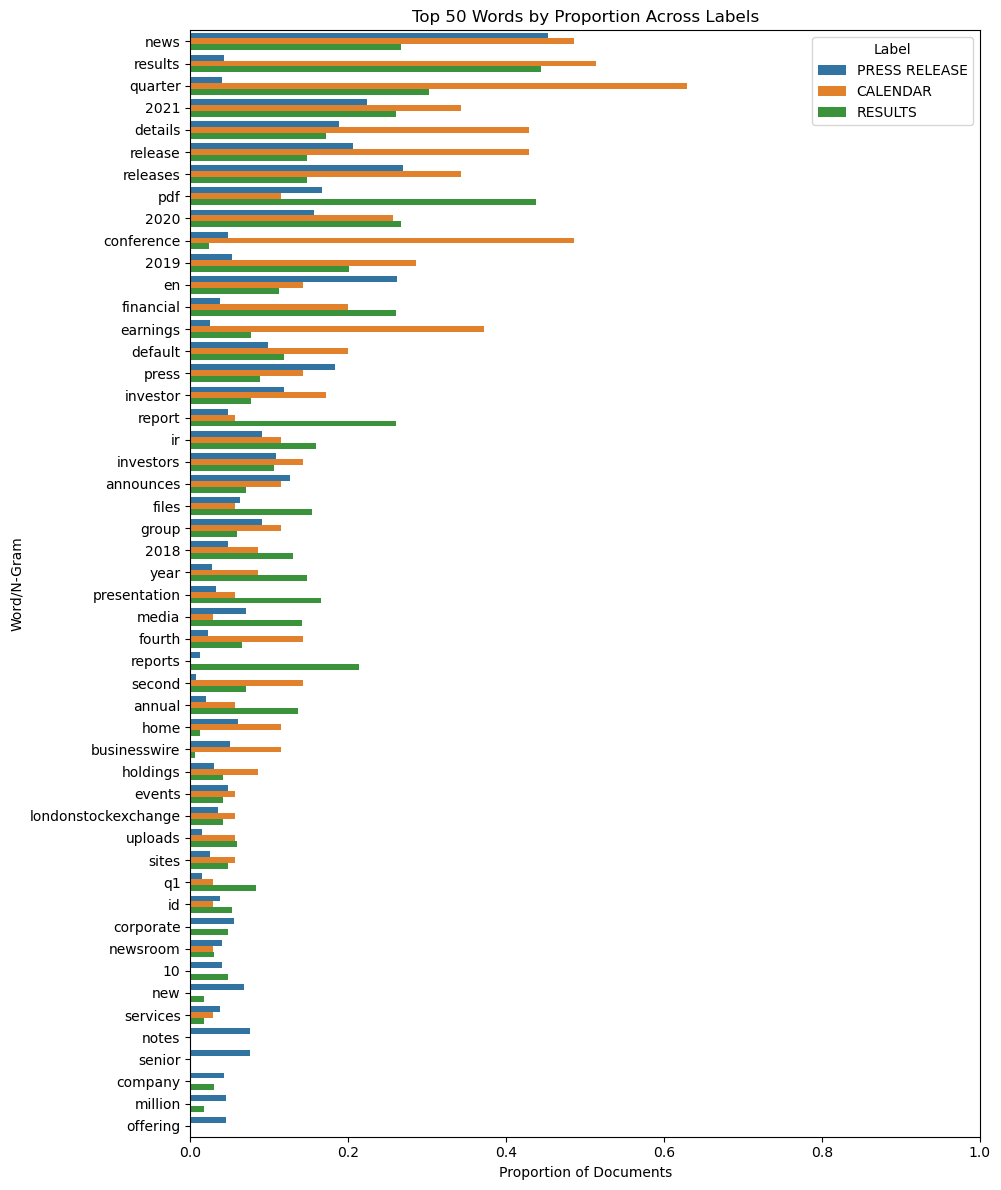

In [16]:
def plot_top_words_proportion(features, feature_names, labels, top_n=50):
    """
    Plots a horizontal barplot of the proportion of documents each top word/ngram is present in,
    using label as the hue.

    Args:
    - features: Sparse matrix of n-gram features.
    - feature_names: Array of n-gram feature names.
    - labels: Series or array of labels corresponding to each row in the feature matrix.
    - label_encoder: A fitted LabelEncoder to translate label integers to class names.
    - top_n: Number of top words/ngrams to consider based on overall frequency.
    """
    # Calculate the overall frequency of each feature across all documents
    feature_df = pd.DataFrame(features.toarray(), columns=feature_names)
    overall_counts = feature_df.sum(axis=0).sort_values(ascending=False)
    
    # Select the top N features based on overall frequency
    top_features = overall_counts.head(top_n).index.tolist()
    
    # Create a DataFrame to hold proportions per label
    proportions = []
    
    for label in labels.unique():
        label_feature_df = feature_df.loc[labels == label, top_features]
        label_proportions = (label_feature_df > 0).mean(axis=0)  # Proportion of docs with the word
        proportions.append(pd.DataFrame({
            'Feature': top_features,
            'Proportion': label_proportions.values,
            'Label': label_encoder.classes_[label]
        }))
    
    # Concatenate all proportions into a single DataFrame
    proportions_df = pd.concat(proportions, ignore_index=True)
    
    # Sort by overall frequency
    proportions_df['Overall'] = proportions_df.groupby('Feature')['Proportion'].transform('sum')
    proportions_df = proportions_df.sort_values('Overall', ascending=False)
    
    # Plot with Seaborn
    plt.figure(figsize=(10, 12))
    sns.barplot(
        data=proportions_df,
        y='Feature',
        x='Proportion',
        hue='Label',
        dodge=True
    )
    plt.title(f'Top {top_n} Words by Proportion Across Labels')
    plt.xlabel('Proportion of Documents')
    plt.ylabel('Word/N-Gram')
    plt.legend(title='Label', loc='upper right')
    plt.tight_layout()
    plt.xlim(0, 1)
    plt.show()

plot_top_words_proportion(train_text_features_iter_1, feature_names_iter_1, train_df.label, top_n=50)


Findings:
- Calendars will not be easy to distinguish from Results ('results' or 'quarter' or date-related words like year are equally present in both classes, which is not surprising as Calendar events looks to be for communicating results.
- The event format like 'Conference' could help


#### Fit and evaluate model

- Using Naive Bayes (multinomial) model for it's simplicity, leave hyperparameters at their default.
  

In [17]:
nb_classifier_iter_1 = MultinomialNB()
nb_classifier_iter_1.fit(train_text_features_iter_1, train_df['label'])

MultinomialNB()

In [18]:
val_text_features_iter_1 = text_step.transform(val_df)

y_pred_iter_1 = nb_classifier_iter_1.predict(val_text_features_iter_1)
y_pred_proba_iter_1 = nb_classifier_iter_1.predict_proba(val_text_features_iter_1)

evaluate_multiclass_model(y_pred=y_pred_iter_1,
                          y_pred_proba=y_pred_proba_iter_1,
                          y_true=val_df.label,
                          model_name='Naive Bayes default'
                         )

[TextVectorizerStep] URLs processed
[TextVectorizerStep] Transforming text features...
--------------------------------------------------------------------------------
Evaluation Metrics: Naive Bayes default
--------------------------------------------------------------------------------
Balanced Accuracy Score: 0.8634
Log Loss: 0.4846
Macro-Averaged F1 Score: 0.8380

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.93      0.87      0.90        86
           2       0.78      0.86      0.82        36

    accuracy                           0.87       129
   macro avg       0.82      0.86      0.84       129
weighted avg       0.87      0.87      0.87       129


Confusion Matrix:
   0   1   2
0  6   1   0
1  2  75   9
2  0   5  31
--------------------------------------------------------------------------------


Findings:
- Decent improvement from baseline
- The model is pretty good at predicting the majority class PRESS RELEASES and the reasonably ok at RESULTS and CALENDAR minority classes
- Only 1 calendar news wasn't found, but there were 2 false positives.
- Interestingly no CALENDAR news was confused with RESULT news! 
- Several Press Releases were predicted as Results, and the other way around.

#### Inspect errors

__False positive CALENDARS__
- These are likely predicted as such because of these are announcements of Conference Calls.
- I'd ask the annotators why are these PRESS RELEASE events, these look pretty CALENDAR-y to me...

In [19]:
print_incorrect_predictions(val_df, y_pred=y_pred_iter_1, y_proba=y_pred_proba_iter_1, true_label=1, predicted_label=0)

Showing 2 incorrect predictions:


,title,url,published_at,label,name,description,location,website,processed_url,predicted_label,proba_0,proba_1,proba_2
94,Mueller Water Products: Mueller Water Products Announces Dates for Fourth Quarter and Full Year 2021 Earnings Release and Conference Call,https://ir.muellerwaterproducts.com/press-releases/2021/10-28-2021-214323406,2021-10-28 20:45:33.650932,1,Mueller Water Products,Supplier of potable water distribution products,United States,https://www.muellerwaterproducts.com/,ir muellerwaterproducts press releases 2021 10 28 2021 214323406,0,0.607550,0.191309,0.201141
53,WPX Energy: Devon Energy Schedules Second-Quarter 2021 Earnings Release and Conference Call,https://www.devonenergy.com/news/2021/Devon-Energy-Schedules-Second-Quarter-2021-Earnings-Release-and-Conference-Call,2021-06-24 14:17:44.053479,1,WPX Energy,Oil and natural gas exploration and production company,United States,https://www.wpxenergy.com/,devonenergy news 2021 Devon Energy Schedules Second Quarter 2021 Earnings Release and Conference Call,0,0.940935,0.014842,0.044223


__False negative CALENDAR:__
- Looks like the word 'Call' is not enough to identify this event correctly, turns out it's not even a feature as it's not frequent enough! 

In [20]:
print_incorrect_predictions(val_df, y_pred=y_pred_iter_1, y_proba=y_pred_proba_iter_1, true_label=0, predicted_label=1)

Showing 1 incorrect predictions:


,title,url,published_at,label,name,description,location,website,processed_url,predicted_label,proba_0,proba_1,proba_2
54,"Brinker: Brinker International, Inc. To Host First Quarter Fiscal 2021 Earnings Call",http://investors.brinker.com/news-releases/news-release-details/brinker-international-inc-host-first-quarter-fiscal-2021,2020-10-21 20:32:22.595074,0,Brinker,Owner of Chili's and Maggiano's Little Italy restaurant chains,United States,https://www.brinker.com/,investors brinker news releases news release details brinker international inc host first quarter fiscal 2021,1,0.290639,0.558039,0.151322


In [21]:
'call' in feature_names_iter_1

False

__False positive RESULT:__
- These are probably predicted as RESULTS because the URL points to pdfs....with RESULTs in them. Also high `proba_2`, as far as these values are reliable for a Naive Bayes model. 
- Again, I'd ask the annotators why are these NOT RESULTS. Depending on the use case I'd reformulate this as multi-label problem, classifying this as RESULT _and_ PRESS RELEASE.

In [22]:
print_incorrect_predictions(val_df, y_pred=y_pred_iter_1, y_proba=y_pred_proba_iter_1, true_label=1, predicted_label=2)

Showing 5 incorrect predictions:


,title,url,published_at,label,name,description,location,website,processed_url,predicted_label,proba_0,proba_1,proba_2
19,Constellium: Press release - Constellium Reports Fourth Quarter and Full Year 2018 Results,https://www.constellium.com/sites/default/files/constellium_reports_fourth_quarter_and_full_year_2018_results.pdf,2019-02-21 12:11:35.019169,1,Constellium,"Designer and manufacture of specialty rolled and extruded aluminum products, serving primarily the aerospace, packaging and automotive end-markets",Netherlands,http://www.constellium.com/,constellium sites default files constellium_reports_fourth_quarter_and_full_year_2018_results pdf,2,0.000840,0.000249,0.998911
34,Matador: Matador Resources Company Reports Fourth Quarter and Full Year 2020 Financial Results and Provides Operational Update,http://www.businesswire.com/news/home/20210223006060/en/Matador-Resources-Company-Reports-Fourth-Quarter-and-Full-Year-2020-Financial-Results-and-Provides-Operational-Update,2021-02-24 10:27:50.11807,1,Matador,Carlyle's Minority Investment Vehicle in CEPSA,,,businesswire news home 20210223006060 en Matador Resources Company Reports Fourth Quarter and Full Year 2020 Financial Results and Provides Operational Update,2,0.056650,0.027740,0.915609
51,"Salt: With +57 points year-on-year, Salt achieves “very good” rating in network test",https://www.salt.ch/media/press/files/2019/2/5/78ec7308-aa77-458f-aa44-b08a00b2b588/404/20190205_PR_Connect_EN.pdf,2019-02-05 08:44:44.462279,1,Salt,Mobile network operator,Switzerland,https://www.salt.ch/,salt ch media press files 2019 2 5 78ec7308 aa77 458f aa44 b08a00b2b588 404 20190205_PR_Connect_EN pdf,2,0.001392,0.084017,0.914591
75,MEG Energy: Year-End,https://www.megenergy.com/sites/default/files/MEGEnergyCorp_YE2020_COMBINED_REPORT_FINAL.pdf,2021-03-03 22:39:28.091663,1,MEG Energy,Oil sands company,Canada,https://www.megenergy.com/,megenergy sites default files MEGEnergyCorp_YE2020_COMBINED_REPORT_FINAL pdf,2,0.006029,0.111879,0.882092
24,Codere: Alternative Performance Measures Q1 2018,https://www.grupocodere.com/en/shareholders-investors/presentations/10/05/2018-alternative-performance-measures-q1-2018/,2018-05-10 22:26:29.330515,1,Codere,Gaming company,Spain,http://www.codere.com/,grupocodere en shareholders investors presentations 10 05 2018 alternative performance measures q1 2018,2,0.003147,0.439208,0.557645


__False negative RESULT__:
- These should be results.
- Maybe including publish month could help?

In [23]:
print_incorrect_predictions(val_df, y_pred=y_pred_iter_1, y_proba=y_pred_proba_iter_1, true_label=2, predicted_label=1)

Showing 5 incorrect predictions:


,title,url,published_at,label,name,description,location,website,processed_url,predicted_label,proba_0,proba_1,proba_2
68,Gestamp: Other significant facts - 10/06/2020 Financial Update pdf 2 MB Download,https://www.gestamp.com/Gestamp11/media/GestampFiles/Shareholders%20Investors/General%20Information/Other%20significant%20facts/2020/2020_06_08-HR-GEST-Financing-Update-(ENG).pdf?ext=.pdf,2020-06-10 08:31:34.09153,2,Gestamp,"Manufacture, designer, developer of metal automotive components",Spain,http://www.gestamp.com/,gestamp Gestamp11 media GestampFiles Shareholders%20Investors General%20Information Other%20significant%20facts 2020 2020_06_08 HR GEST Financing Update (ENG) pdf?ext= pdf,1,0.002864,0.738696,0.258440
23,Fluidra: Fluidra accelerates results despite Covid-19 rising net profit to 54.9 million euros,https://www.fluidra.com/press-releases/fluidra-accelerates-results-despite-covid-19-rising-net-profit-to-54-9-million-euros,2020-07-31 06:37:33.18011,2,Fluidra,"Products, services for the residential and commerical pool markets",Spain,https://www.fluidra.com,fluidra press releases fluidra accelerates results despite covid 19 rising profit to 54 9 million euros,1,0.066978,0.853197,0.079825
79,Summit Midstream Partners: Form 10-Q,https://summitmidstreampartnerslp.gcs-web.com/sec-filings/sec-filing/10-q/0001564590-21-025535,2021-08-02 12:07:20.986314,2,Summit Midstream Partners,Provider of midstream energy infrastructure,United States,http://www.summitmidstream.com/,summitmidstreampartnerslp gcs web sec filings sec filing 10 q 0001564590 21 025535,1,0.020190,0.557948,0.421863
99,"Norske Skog: Strong operating performance, challenging markets",https://www.norskeskog.com/Investors/Press-releases/English-press-releases/Strong-operating-performance--challenging-markets?PID=4241&M=NewsV2&Action=1,2020-02-06 06:52:23.364132,2,Norske Skog,Pulp and paper company,Norway,http://www.norskeskog.com/,norskeskog Investors Press releases English press releases Strong operating performance challenging markets?PID=4241&M=NewsV2&Action=1,1,0.025952,0.810504,0.163543
38,Tronox: Tronox Announces the Pricing of an Upsized Secondary Public Offering by Exxaro Resources Limited,https://investor.tronox.com/press-releases/press-releases-details/2021/Tronox-Announces-the-Pricing-of-an-Upsized-Secondary-Public-Offering-by-Exxaro-Resources-Limited/default.aspx,2021-02-25 01:39:49.854176,2,Tronox,Manufactures specialty chemical products,United States,https://www.tronox.com/,investor tronox press releases press releases details 2021 Tronox Announces the Pricing of an Upsized Secondary Public Offering by Exxaro Resources Limited default,1,0.000655,0.999155,0.000190


__Findings:__
- Maybe add more features to the bag, e.g. 'call' is missing.
- Based on the false negative Results, companies seem to report their quarterly earnings ~2 months after the quarter ended. Extracting the month out of the publication date as well as the location of the company (which determines when the financial year starts/ends might help us differentiate RESULTS form regular press releases?)

## Iteration #2 

#### Published month and location
- Especially the RESULTS category should have some regularity in terms of published date, and the regularity may well depend on the location (juristiction) the company operates in.

In [24]:
location_counts = train_df.location.value_counts(); location_counts.head(10)

location
United States     230
United Kingdom     78
Germany            38
France             32
Italy              26
Sweden             25
Spain              17
Netherlands        17
Norway             16
Switzerland        12
Name: count, dtype: int64

In [25]:
train_df['published_month'] = pd.to_datetime(train_df['published_at'], errors='coerce').dt.month
train_df['location_clean'] = train_df['location'].apply(
    lambda loc: loc if location_counts[loc] >= 30 else 'Other'
)

train_df[['published_at', 'published_month', 'location_clean']].head()

,published_at,published_month,location_clean
0,2021-06-04 14:35:11.217723,6,United Kingdom
1,2019-09-26 10:34:47.199313,9,Germany
2,2020-03-26 08:57:02.471162,3,Other
3,2021-03-30 06:47:28.806813,3,Other
4,2021-02-26 11:30:14.931078,2,United States


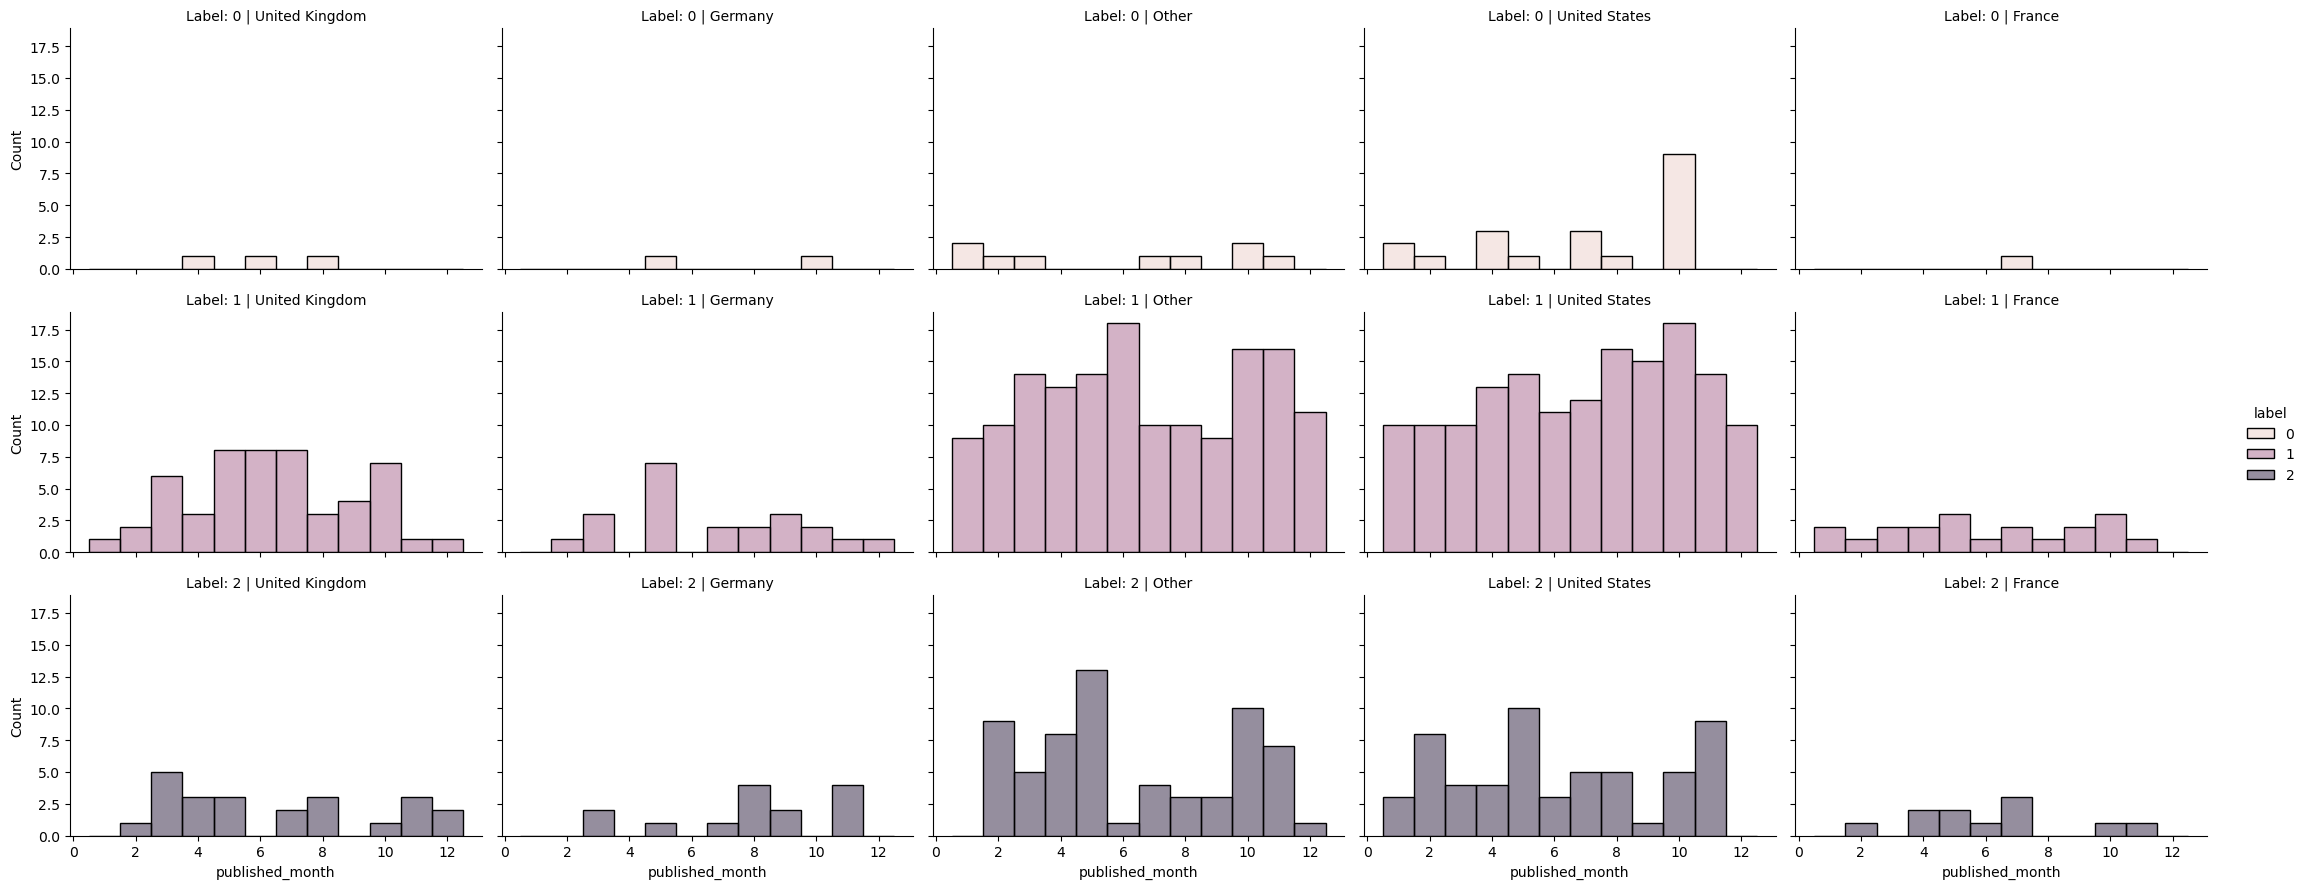

In [26]:
g = sns.displot(data=train_df, x='published_month', col='location_clean', row='label', hue='label', discrete=True, height=3, aspect=1.5)
g.set_titles(row_template="Label: {row_name}", col_template="{col_name}")
plt.show()

Findings:
- There is some evidence for news regularity by location:
  - In the US, quarterly RESULTS tend to be reported 2 months after end of quarter
  - Year-end CALENDAR events seem to be announced in October (and midyear maybe April)


#### Define new published month and location transformers, as well as a separate one identifying the presence of the word 'call'

In [27]:
class PublishedMonthFeatureStep(FeaturePipelineStep):
    def transform(self, df):
        self.log("Transforming dates...")
        df['published_month'] = pd.to_datetime(df['published_at'], errors='coerce').dt.month
        df['published_month'] = df['published_month'].fillna(-1).astype(int)
        return df[['published_month']].to_numpy()

In [28]:
class LocationFeatureStep(FeaturePipelineStep):
    def __init__(self, min_frequency=5):
        self.encoder = OneHotEncoder(handle_unknown='infrequent_if_exist',
                                     sparse_output=True,
                                     min_frequency=min_frequency)

    def fit(self, df):
        self.log("Fitting the one-hot encoder...")
        self.encoder.fit(df[['location']])

    def transform(self, df):
        self.log("Transforming locations...")
        return self.encoder.transform(df[['location']])

In [29]:
class IsCallFeatureStep(FeaturePipelineStep):
    def __init__(self):
        pass  # No initialization needed for this simple step

    def fit(self, df):
        # No fitting required for this step
        self.log("No fitting required for IsCallFeatureStep.")

    def transform(self, df):
        self.log("Transforming data to detect 'call' in URL and title...")
        # Check for 'call' in 'url' and 'title', case-insensitively
        df['is_call_url'] = df['url'].str.contains(r'\bcall\b', case=False, na=False).astype(int)
        df['is_call_title'] = df['title'].str.contains(r'\bcall\b', case=False, na=False).astype(int)
        # Combine both into a single feature (you can keep them separate if desired)
        df['is_call'] = (df['is_call_url'] | df['is_call_title']).astype(int)
        return df[['is_call']].to_numpy()

In [30]:
text_vectorizer_iter_2 = CountVectorizer(
    ngram_range=(1, 1),
    analyzer='word',
    stop_words='english',
    binary=True,
    min_df=0.005
)

In [31]:
pipeline_iter_2 = FeaturePipeline(steps=[
    TextVectorizerStep(text_vectorizer_iter_2),
    PublishedMonthFeatureStep(),
    LocationFeatureStep(min_frequency=5),
    IsCallFeatureStep()
])

In [32]:
train_features_iter_2 = pipeline_iter_2.fit_transform(train_df)

[TextVectorizerStep] URLs processed
[TextVectorizerStep] Fitting the text vectorizer...
[LocationFeatureStep] Fitting the one-hot encoder...
[IsCallFeatureStep] No fitting required for IsCallFeatureStep.
[TextVectorizerStep] Transforming text features...
[PublishedMonthFeatureStep] Transforming dates...
[LocationFeatureStep] Transforming locations...
[IsCallFeatureStep] Transforming data to detect 'call' in URL and title...


In [33]:
print("Features Shape:", train_features_iter_2.shape)

Features Shape: (601, 348)


#### Fit and evaluate model

In [34]:
nb_classifier_iter_2 = MultinomialNB()
nb_classifier_iter_2.fit(train_features_iter_2, train_df['label'])

MultinomialNB()

In [35]:
val_features_iter_2 = pipeline_iter_2.transform(val_df)

y_pred_iter_2 = nb_classifier_iter_2.predict(val_features_iter_2)
y_pred_proba_iter_2 = nb_classifier_iter_2.predict_proba(val_features_iter_2)

evaluate_multiclass_model(y_pred=y_pred_iter_2,
                          y_pred_proba=y_pred_proba_iter_2,
                          y_true=val_df.label,
                          model_name='Naive Bayes iter 2'
                         )

[TextVectorizerStep] Transforming text features...
[PublishedMonthFeatureStep] Transforming dates...
[LocationFeatureStep] Transforming locations...
[IsCallFeatureStep] Transforming data to detect 'call' in URL and title...
--------------------------------------------------------------------------------
Evaluation Metrics: Naive Bayes iter 2
--------------------------------------------------------------------------------
Balanced Accuracy Score: 0.8902
Log Loss: 0.4733
Macro-Averaged F1 Score: 0.8120

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.95      0.84      0.89        86
           2       0.71      0.83      0.77        36

    accuracy                           0.84       129
   macro avg       0.77      0.89      0.81       129
weighted avg       0.87      0.84      0.85       129


Confusion Matrix:
   0   1   2
0  7   0   0
1  2  72  12
2  2   4  30
------------------

__Findings:__
- Looks like adding more features actually _worsen_ the results slightly, probably a lot of noise will be added to the training set.


## Iteration #3

- Let's use the previous vectoriser with more frequent words, and focus on finding the best model / hyperparameters. 

In [36]:
# Exactly the same as in iteration 1
text_vectorizer_iter_3 = CountVectorizer(
    ngram_range=(1, 1),
    analyzer='word',
    stop_words='english',
    binary=True,
    min_df=0.01
)

pipeline_iter_3 = FeaturePipeline(steps=[
    TextVectorizerStep(text_vectorizer_iter_3),
    PublishedMonthFeatureStep(),
    LocationFeatureStep(min_frequency=5),
    IsCallFeatureStep()
])

train_features_iter_3 = pipeline_iter_3.fit_transform(train_df)

train_features_iter_3.shape

[TextVectorizerStep] URLs processed
[TextVectorizerStep] Fitting the text vectorizer...
[LocationFeatureStep] Fitting the one-hot encoder...
[IsCallFeatureStep] No fitting required for IsCallFeatureStep.
[TextVectorizerStep] Transforming text features...
[PublishedMonthFeatureStep] Transforming dates...
[LocationFeatureStep] Transforming locations...
[IsCallFeatureStep] Transforming data to detect 'call' in URL and title...


(601, 189)

In [37]:
sum(train_df.location.value_counts() > 5)

17

189 features = 169 text-based + 1 for the word 'call' + 1 published month + 17 frequent location + 1 'other' location, checks out

#### Fit and evaluate model

In [38]:
def train_and_select_best_model(X, y):
    """
    Train multiple models, perform hyperparameter tuning, and select the best model based on log loss.
    
    Args:
    - X: Features (sparse or dense matrix).
    - y: Target labels (array-like).
    
    Returns:
    - best_model: Fitted estimator with the best performance.
    - results_df: DataFrame summarizing model performance and best hyperparameters.
    - all_models: Dictionary of all fitted models with unique IDs as keys.
    """
    # Define models and their parameter grids
    models = {
        "MultinomialNB": (MultinomialNB(), {
            "alpha": [0.1, 0.5, 1.0]
        }),
        "GradientBoostingClassifier": (GradientBoostingClassifier(random_state=random_seed), {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.05, 0.1, 0.2]
        }),
        "RandomForestClassifier": (RandomForestClassifier(random_state=random_seed), {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20]
        }),
        "LogisticRegression": (LogisticRegression(solver="liblinear", random_state=random_seed), {
            "C": [0.1, 1, 10]
        })
    }
    
    results = []
    best_score = float('inf')
    best_model = None
    all_models = {}  # Dictionary to store all fitted models

    for name, (model, param_grid) in models.items():
        print(f"Training {name}...")

        # Use GridSearchCV with log loss as the scoring metric
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=make_scorer(log_loss, greater_is_better=False, response_method="predict_proba"),
            cv=5,
            verbose=1
        )
        grid_search.fit(X, y)

        # Store results
        mean_score = -grid_search.best_score_  # Negate because log_loss is negative in make_scorer
        best_params = grid_search.best_params_
        model_id = f"{name}_{'_'.join(f'{k}={v}' for k, v in best_params.items())}"
        results.append({
            "Model": name,
            "Best Params": best_params,
            "Log Loss": mean_score,
            "Model ID": model_id
        })

        # Add the fitted model to the dictionary
        all_models[model_id] = grid_search.best_estimator_

        print(f"{name}: Best Log Loss = {mean_score:.4f}, Params = {best_params}")

        # Update the best model if this one is better
        if mean_score < best_score:
            best_score = mean_score
            best_model = grid_search.best_estimator_

    # Print summary
    results_df = pd.DataFrame(results)
    print("\nModel Comparison:")
    print(results_df.sort_values("Log Loss"))

    # Refit the best model on the entire training dataset
    print(f"\nRefitting the best model ({best_model.__class__.__name__}) on the entire training set...")
    best_model.fit(X, y)

    return best_model, results_df, all_models

best_model, model_comparison, all_models = train_and_select_best_model(train_features_iter_3, train_df["label"])

# Display the results
print(f"\nWinner Model: {best_model.__class__.__name__}")
print(best_model)

Training MultinomialNB...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
MultinomialNB: Best Log Loss = 0.6460, Params = {'alpha': 1.0}
Training GradientBoostingClassifier...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
GradientBoostingClassifier: Best Log Loss = 0.4576, Params = {'learning_rate': 0.1, 'n_estimators': 50}
Training RandomForestClassifier...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
RandomForestClassifier: Best Log Loss = 0.4195, Params = {'max_depth': None, 'n_estimators': 200}
Training LogisticRegression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
LogisticRegression: Best Log Loss = 0.4514, Params = {'C': 1}

Model Comparison:
                        Model                                 Best Params  \
2      RandomForestClassifier    {'max_depth': None, 'n_estimators': 200}   
3          LogisticRegression                                    {'C': 1}   
1  GradientBoostingClassifier  {'learning_rate': 0.1

In [39]:
val_features_iter_3 = pipeline_iter_3.transform(val_df)

y_pred_iter_3 = best_model.predict(val_features_iter_3)
y_pred_proba_iter_3 = best_model.predict_proba(val_features_iter_3)

evaluate_multiclass_model(y_pred=y_pred_iter_3,
                          y_pred_proba=y_pred_proba_iter_3,
                          y_true=val_df.label,
                          model_name='Random Forest Model'
                         )

[TextVectorizerStep] Transforming text features...
[PublishedMonthFeatureStep] Transforming dates...
[LocationFeatureStep] Transforming locations...
[IsCallFeatureStep] Transforming data to detect 'call' in URL and title...
--------------------------------------------------------------------------------
Evaluation Metrics: Random Forest Model
--------------------------------------------------------------------------------
Balanced Accuracy Score: 0.9251
Log Loss: 0.3064
Macro-Averaged F1 Score: 0.8937

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.93      0.94      0.94        86
           2       0.91      0.83      0.87        36

    accuracy                           0.91       129
   macro avg       0.87      0.93      0.89       129
weighted avg       0.92      0.91      0.91       129


Confusion Matrix:
   0   1   2
0  7   0   0
1  2  81   3
2  0   6  30
-----------------

Findings:
- After optimisation, we have clearly outperformed the first iteration. 

## Evaluate all iterations against the test set

In [40]:
all_fitted_models = {'Naive Bayes iter 1': (nb_classifier_iter_1, text_step),
                       'Naive Bayes iter 2': (nb_classifier_iter_2, pipeline_iter_2)
                      }
for model_id, model_object in all_models.items():
    all_fitted_models[model_id] = (model_object, pipeline_iter_3)


In [41]:
model_performance = dict()

for model_id, (model_object, transformer) in all_fitted_models.items():

    test_features = transformer.transform(test_df)
    y_pred = model_object.predict(test_features)
    y_pred_proba = model_object.predict_proba(test_features)
    f1 = f1_score(test_df.label, y_pred, average='macro')
    balanced_acc = balanced_accuracy_score(test_df.label, y_pred)
    ll = log_loss(test_df.label, y_pred_proba)

    model_performance[model_id] = {'f1': f1, 'balanced_accuracy': balanced_acc, 'logloss': ll}

model_performance

[TextVectorizerStep] URLs processed
[TextVectorizerStep] Transforming text features...
[TextVectorizerStep] Transforming text features...
[PublishedMonthFeatureStep] Transforming dates...
[LocationFeatureStep] Transforming locations...
[IsCallFeatureStep] Transforming data to detect 'call' in URL and title...
[TextVectorizerStep] Transforming text features...
[PublishedMonthFeatureStep] Transforming dates...
[LocationFeatureStep] Transforming locations...
[IsCallFeatureStep] Transforming data to detect 'call' in URL and title...
[TextVectorizerStep] Transforming text features...
[PublishedMonthFeatureStep] Transforming dates...
[LocationFeatureStep] Transforming locations...
[IsCallFeatureStep] Transforming data to detect 'call' in URL and title...
[TextVectorizerStep] Transforming text features...
[PublishedMonthFeatureStep] Transforming dates...
[LocationFeatureStep] Transforming locations...
[IsCallFeatureStep] Transforming data to detect 'call' in URL and title...
[TextVectorizerSt

{'Naive Bayes iter 1': {'f1': 0.6791641820711588,
  'balanced_accuracy': 0.7064814814814815,
  'logloss': 0.4961598485259589},
 'Naive Bayes iter 2': {'f1': 0.6719527683383104,
  'balanced_accuracy': 0.6805010893246187,
  'logloss': 0.5357761794102363},
 'MultinomialNB_alpha=1.0': {'f1': 0.6768292682926829,
  'balanced_accuracy': 0.6958061002178649,
  'logloss': 0.5088812848407323},
 'GradientBoostingClassifier_learning_rate=0.1_n_estimators=50': {'f1': 0.7909356725146198,
  'balanced_accuracy': 0.7788126361655774,
  'logloss': 0.4234043340144597},
 'RandomForestClassifier_max_depth=None_n_estimators=200': {'f1': 0.7318764568764569,
  'balanced_accuracy': 0.7246732026143791,
  'logloss': 0.6842541175947964},
 'LogisticRegression_C=1': {'f1': 0.6928908999497235,
  'balanced_accuracy': 0.685511982570806,
  'logloss': 0.4375683253308972}}

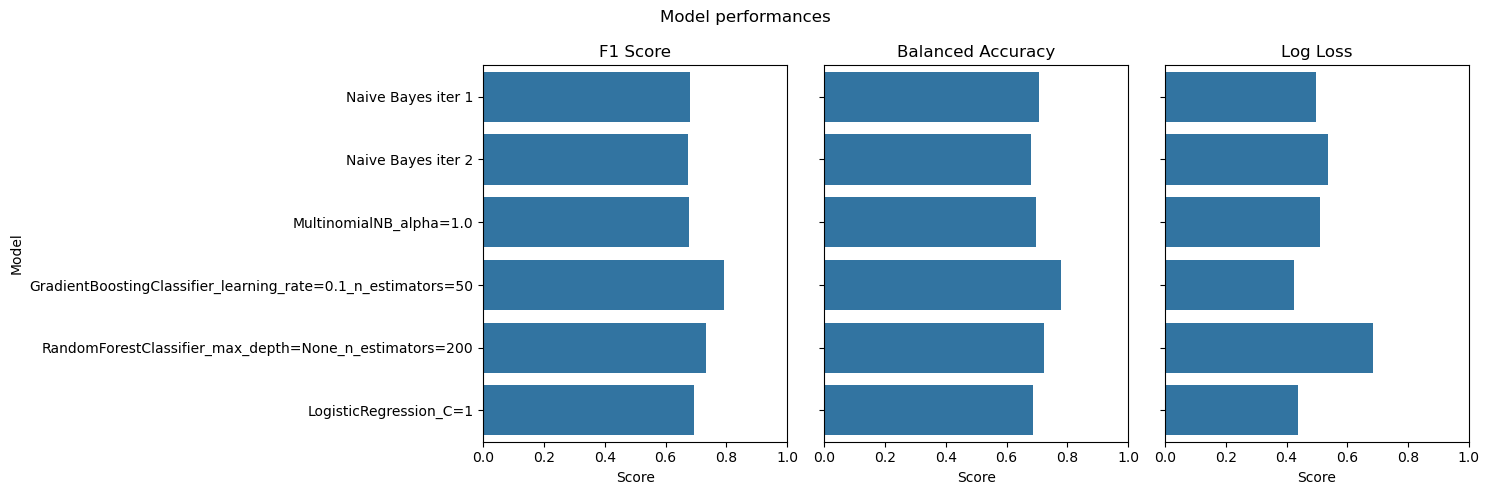

In [42]:
data = []
for model, metrics in model_performance.items():
    for metric, score in metrics.items():
        data.append({'Model': model, 'Metric': metric, 'Score': score})
df = pd.DataFrame(data)

# Setting up the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Plot for F1 Score
sns.barplot(data=df[df['Metric'] == 'f1'], y='Model', x='Score', ax=axes[0], orient='h')
axes[0].set_title('F1 Score')
axes[0].set_xlim(0, 1)
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Model')

# Plot for Balanced Accuracy
sns.barplot(data=df[df['Metric'] == 'balanced_accuracy'], y='Model', x='Score', ax=axes[1], orient='h')
axes[1].set_title('Balanced Accuracy')
axes[1].set_xlim(0, 1)
axes[1].set_xlabel('Score')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])  # Remove model IDs

# Plot for Log Loss
sns.barplot(data=df[df['Metric'] == 'logloss'], y='Model', x='Score', ax=axes[2], orient='h')
axes[2].set_title('Log Loss')
axes[2].set_xlim(0, 1)
axes[2].set_xlabel('Score')
axes[2].set_ylabel('')
axes[2].set_yticklabels([])  # Remove model IDs

# Adjust layout
plt.suptitle('Model performances')
plt.tight_layout()
plt.show()

In [43]:
test_features = pipeline_iter_3.transform(test_df)

y_pred_best = all_models['GradientBoostingClassifier_learning_rate=0.1_n_estimators=50'].predict(test_features)
y_pred_proba_best = all_models['GradientBoostingClassifier_learning_rate=0.1_n_estimators=50'].predict_proba(test_features)

evaluate_multiclass_model(y_pred_best, y_pred_proba_best, test_df.label, model_name='best_model')

[TextVectorizerStep] Transforming text features...
[PublishedMonthFeatureStep] Transforming dates...
[LocationFeatureStep] Transforming locations...
[IsCallFeatureStep] Transforming data to detect 'call' in URL and title...
--------------------------------------------------------------------------------
Evaluation Metrics: best_model
--------------------------------------------------------------------------------
Balanced Accuracy Score: 0.7788
Log Loss: 0.4234
Macro-Averaged F1 Score: 0.7909

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.90      0.91      0.90        85
           2       0.81      0.81      0.81        36

    accuracy                           0.86       129
   macro avg       0.81      0.78      0.79       129
weighted avg       0.86      0.86      0.86       129


Confusion Matrix:
   0   1   2
0  5   2   1
1  2  77   6
2  0   7  29
--------------------------

__Misclassified CALENDAR__

In [44]:
print_incorrect_predictions(test_df, y_pred_best, y_pred_proba_best, true_label=0, predicted_label=1)
print_incorrect_predictions(test_df, y_pred_best, y_pred_proba_best, true_label=0, predicted_label=2)

Showing 2 incorrect predictions:


,title,url,published_at,label,name,description,location,website,processed_url,published_month,is_call_url,is_call_title,is_call,predicted_label,proba_0,proba_1,proba_2
105,Talos Energy: Add to iCalendar,https://www.talosenergy.com/DownloadICal.aspx?id=883,2021-09-08 11:01:43.561619,0,Talos Energy,"Engages in exploration, development, and production of oil and natural gas properties.",United States,https://www.talosenergy.com/home/default.aspx,talosenergy DownloadICal aspx?id=883,9,0,0,0,1,0.006589,0.934276,0.059135
64,Summit Midstream Partners: Add to Outlook,https://summitmidstreampartnerslp.gcs-web.com/node/11536/ics,2020-10-29 20:53:45.579582,0,Summit Midstream Partners,Provider of midstream energy infrastructure,United States,http://www.summitmidstream.com/,summitmidstreampartnerslp gcs web node 11536 ics,10,0,0,0,1,0.006559,0.929926,0.063515


Showing 1 incorrect predictions:


,title,url,published_at,label,name,description,location,website,processed_url,published_month,is_call_url,is_call_title,is_call,predicted_label,proba_0,proba_1,proba_2
108,Element Solutions: 2021 Third Quarter Financial Results Call,https://ir.elementsolutionsinc.com/ir-calendar/detail/2526/2021-third-quarter-financial-results-call,2021-10-14 12:39:18.514286,0,Element Solutions,Chemicals company,United States,http://www.platformspecialtyproducts.com/,ir elementsolutionsinc ir calendar detail 2526 2021 third quarter financial results call,10,1,1,1,2,0.279512,0.110771,0.609717


## Overall findings
- In the final evaluation on the test set even the best model (based on validation performance) stuggled with identifying the rarest CALENDAR event.
- The best model on the validation set (random forest) has proved to be the worst performer on the test set, while the GBoost model seemed to generalise better.
- If I had more time, looking into 2-grams could be a potential direction, as well as using embeddings, e.g. to leverage the similarity in meaning of the different ways to communicate financial RESULTs or setting up CALENDAR events...
- ...but I'd rather focus on learning more about the real difference between the LABELS is question, and whether or not these are the best labels